# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The dataset represents **17 campaigns** that occurred between May 2008 and November 2010, corresponding to a total of **79354 contacts**

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn import set_config
set_config(display="diagram")
import time

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [5]:
# build the data
X = df.drop('y', axis=1)
y = df['y']

# Build the transformer to transform the data
y = LabelEncoder().fit_transform(y)
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [10]:
coltransformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [17]:
# baseline model. Use dummy classifier

baseline_pipe = Pipeline([
    ('transformer', coltransformer),
    ('dummy_cls', DummyClassifier())
])

baseline_pipe.fit(X, y)
baseline_test_score = dummy_clf.score(X_test, y_test)
baseline_train_score = dummy_clf.score(X_train, y_train)

baseline_pipe


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('dummy_cls', DummyClassifier())])

In [16]:
print('Baseline train score ', baseline_train_score)
print('Baseline test  score ', baseline_test_score)

Baseline train score  0.887556904400607
Baseline test  score  0.8865015780529255


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [18]:
# Logistic Regression
log_pipe = Pipeline([
    ('transformer', coltransformer),
    ('log_cls', LogisticRegression())
])

log_pipe.fit(X_train, y_train)
log_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('log_cls', LogisticRegression())])

### Problem 9: Score the Model

What is the accuracy of your model?

In [21]:
log_train_score = log_pipe.score(X_train, y_train)
log_test_score = log_pipe.score(X_test, y_test)

print('Logistic Regression Train Score ', log_train_score)
print('Logistic Regression Test  Score ', log_test_score)

Logistic Regression Train Score  0.9118361153262519
Logistic Regression Test  Score  0.911143481427531


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [24]:
# List of models with default parameters
default_models = {
    'knn': KNeighborsClassifier(),
    'logisticregression': LogisticRegression(),
    'svc': SVC(),
    'decisiontreeclassifier': DecisionTreeClassifier()
}

In [25]:
# Get the results for models with default parameters
default_results = []
for name, model in default_models.items() :
    pipe = Pipeline([
        ('transformer', coltransformer),
        ('cls', model)
    ])
    # Fit the model and measure the time
    start_time = time.time()
    pipe.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    # Get the scores
    train_score = pipe.score(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    # Build the results array
    default_results.append([name, train_time, train_score, test_score])

# Build the dataframe from results array
default_data = pd.DataFrame(default_results, columns=['Model', 'Train Time', 'Train Score', 'Test Score'])
default_data.set_index('Model', inplace=True)

print(default_data)

                        Train Time  Train Score  Test Score
Model                                                      
knn                       0.079654     0.928589    0.903010
logisticregression        0.308572     0.911836    0.911143
svc                       8.764690     0.921700    0.911143
decisiontreeclassifier    0.198201     1.000000    0.884438


Text(0.5, 0.98, 'Models with default Parameters')

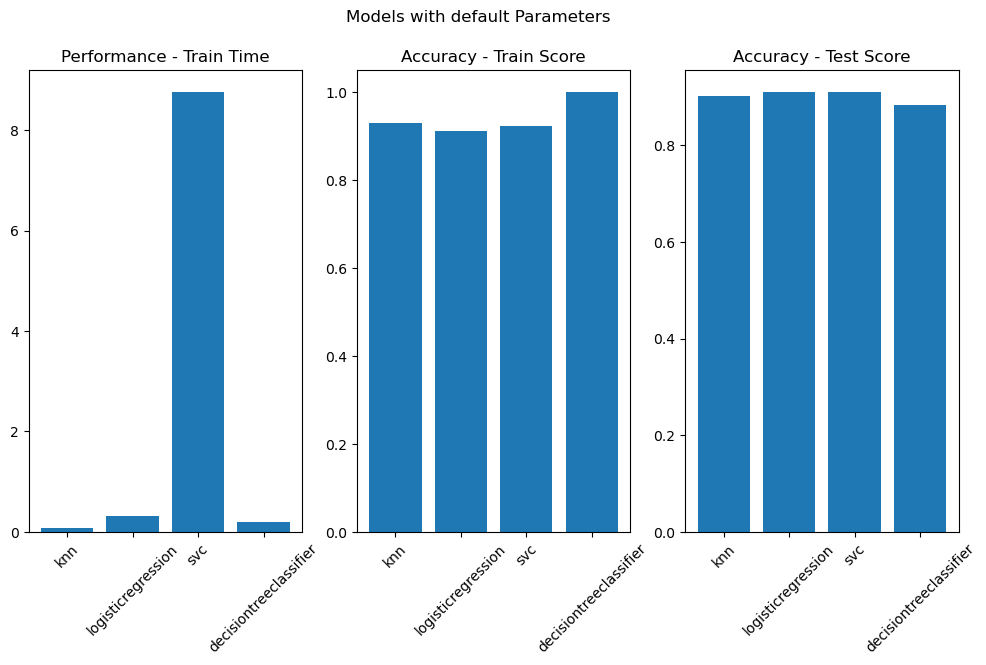

In [46]:
#plot the data for default parameters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(12, 6)
ax1.bar(default_data.index, default_data['Train Time'])
ax1.tick_params(axis='x', rotation=45)
ax2.bar(default_data.index, default_data['Train Score'])
ax2.tick_params(axis='x', rotation=45)
ax3.bar(default_data.index, default_data['Test Score'])
ax3.tick_params(axis='x', rotation=45)
ax1.title.set_text('Performance - Train Time')
ax2.title.set_text('Accuracy - Train Score')
ax3.title.set_text('Accuracy - Test Score')
fig.suptitle('Models with default Parameters')


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [26]:
grid_models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__kernel': ['linear', 'rbf'], 'svc__C': [0.1, 1, 10]}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})
}

In [29]:
grid_results = []
best_params = []
for name, (model, params) in grid_models.items() :
    pipe = Pipeline([
        ('transformer', coltransformer),
        (name, model)
    ])
    grid = GridSearchCV(pipe, param_grid=params, cv = 5, n_jobs=1)
    # Fit the model and measure the time
    start_time = time.time()
    grid.fit(X_train, y_train)
    end_time = time.time()
    train_time = (end_time - start_time)/len(grid.cv_results_['mean_fit_time'])
    
    # Get the scores
    best_est = grid.best_estimator_
    train_score = best_est.score(X_train, y_train)
    test_score = best_est.score(X_test, y_test)
    # Build the results array
    grid_results.append([name, train_time, train_score, test_score])
    best_params.append(grid.best_params_)

# Build the dataframe from results array
grid_data = pd.DataFrame(grid_results, columns=['Model', 'Train Time', 'Train Score', 'Test Score'])
grid_data.set_index('Model', inplace=True)

print(grid_data)

                        Train Time  Train Score  Test Score
Model                                                      
knn                       1.335178     0.924219    0.904467
logisticregression        2.123875     0.911836    0.911143
svc                      73.841391     0.921700    0.911143
decisiontreeclassifier    0.732583     0.917420    0.915028


In [30]:
print(best_params)

[{'knn__n_neighbors': 7}, {'logisticregression__C': 1}, {'svc__C': 1, 'svc__kernel': 'rbf'}, {'decisiontreeclassifier__max_depth': 5}]


Text(0.5, 0.98, 'Models with Grid Parameters')

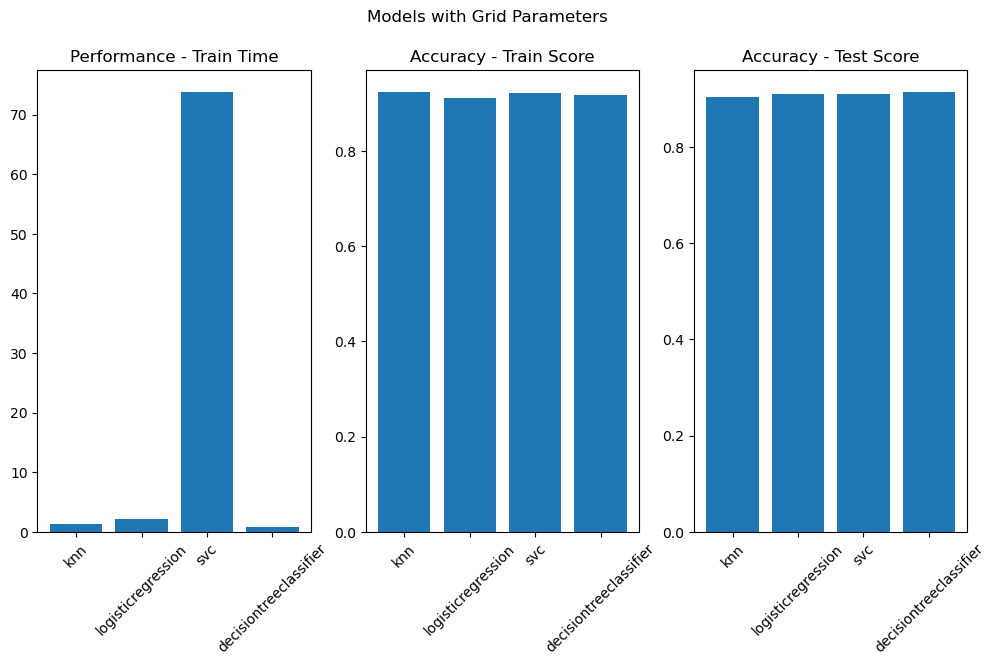

In [47]:
#plot the data for grid parameters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(12, 6)
ax1.bar(grid_data.index, grid_data['Train Time'])
ax1.tick_params(axis='x', rotation=45)
ax2.bar(grid_data.index, grid_data['Train Score'])
ax2.tick_params(axis='x', rotation=45)
ax3.bar(grid_data.index, grid_data['Test Score'])
ax3.tick_params(axis='x', rotation=45)
ax1.title.set_text('Performance - Train Time')
ax2.title.set_text('Accuracy - Train Score')
ax3.title.set_text('Accuracy - Test Score')
fig.suptitle('Models with Grid Parameters')

**Findings**

* All models performed better in terms of accuracy compared to the baseline model (DummyClassifier)
* SVM had good accuracy on both train and test data, but really lacked in performance compared to all other models
* DecisionTreeClassifier performed the best both in terms of performance and accuracy of predictions on test data.
* Different grid parameters were tried with each model. Due to limitation of computation resources, only a limited parameters were tried. The best parameters for each model are as follows
  * KNearestNeighbor : n_neighbors = 7
  * LogisticRegression : C = 1
  * SVC : C = 1; kernel = 'rbf'
  * DecisionTreeClassifier : max_depth = 5